In [ ]:
## Business Objective

The goal of this analysis is to understand retail customer purchasing behavior and identify distinct customer segments based on transaction history.

By segmenting customers using Recency, Frequency, and Monetary (RFM) metrics, this project aims to support:
- Targeted marketing strategies
- Customer retention efforts
- Revenue optimization initiatives

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline

In [3]:
Retail = pd.read_csv("https://raw.githubusercontent.com/Hiddensensu/RetailData2024/main/Retail_Transaction_Dataset.csv")
Retail

,CustomerID,ProductID,Quantity,Price,TransactionDate,PaymentMethod,StoreLocation,ProductCategory,DiscountApplied(%),TotalAmount
0,109318,C,7,80.079844,12/26/2023 12:32,Cash,"176 Andrew Cliffs\nBaileyfort, HI 93354",Books,18.677100,455.862764
1,993229,C,4,75.195229,8/5/2023 0:00,Cash,"11635 William Well Suite 809\nEast Kara, MT 19483",Home Decor,14.121365,258.306546
2,579675,A,8,31.528816,3/11/2024 18:51,Cash,"910 Mendez Ville Suite 909\nPort Lauraland, MO...",Books,15.943701,212.015651
3,799826,D,5,98.880218,10/27/2023 22:00,PayPal,"87522 Sharon Corners Suite 500\nLake Tammy, MO...",Books,6.686337,461.343769
4,121413,A,7,93.188512,12/22/2023 11:38,Cash,"0070 Michelle Island Suite 143\nHoland, VA 80142",Electronics,4.030096,626.030484
...,...,...,...,...,...,...,...,...,...,...
99995,726461,A,2,56.078258,7/17/2023 16:59,Credit Card,"3632 Darren Station Apt. 553\nEricaborough, RI...",Clothing,18.345145,91.581240
99996,328056,A,6,88.516406,5/30/2023 9:04,Credit Card,"821 Taylor Shoals\nEvansville, IL 70845",Electronics,3.995541,509.878179
99997,887304,B,4,72.385564,8/25/2023 7:59,Credit Card,"50653 Kara Lakes\nStephanieborough, RI 94492",Clothing,17.423979,239.092472
99998,326401,C,5,66.542239,2/5/2024 19:45,PayPal,"18756 Mcfarland Way Suite 866\nBarnettside, PR...",Electronics,14.345018,284.983717


In [4]:
payment_counts = Retail['PaymentMethod'].value_counts()
payment_counts

PaymentMethod
PayPal         25067
Credit Card    25034
Cash           25008
Debit Card     24891
Name: count, dtype: int64

In [5]:
Retail.shape

(100000, 10)

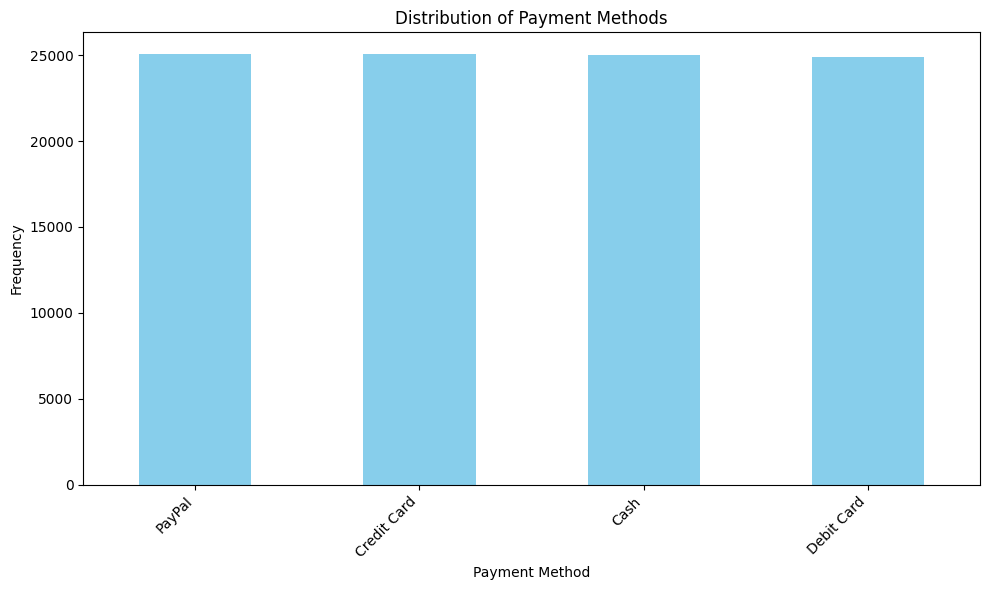

In [6]:
plt.figure(figsize=(10, 6))
payment_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Payment Methods')
plt.xlabel('Payment Method')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

C:\Users\17185\AppData\Local\Temp\ipykernel_39272\1781595376.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='PaymentMethod', y='Price', data=Retail, palette='Set2')


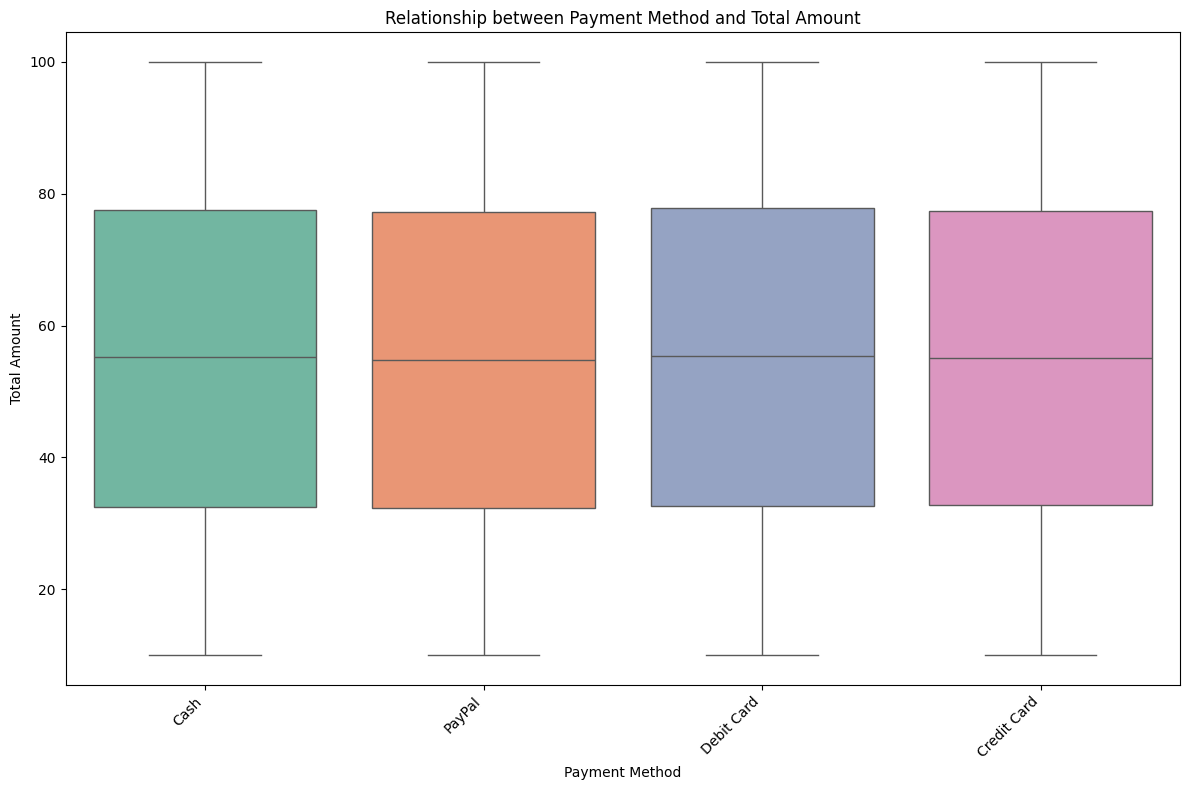

In [7]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='PaymentMethod', y='Price', data=Retail, palette='Set2')
plt.title('Relationship between Payment Method and Total Amount')
plt.xlabel('Payment Method')
plt.ylabel('Total Amount')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

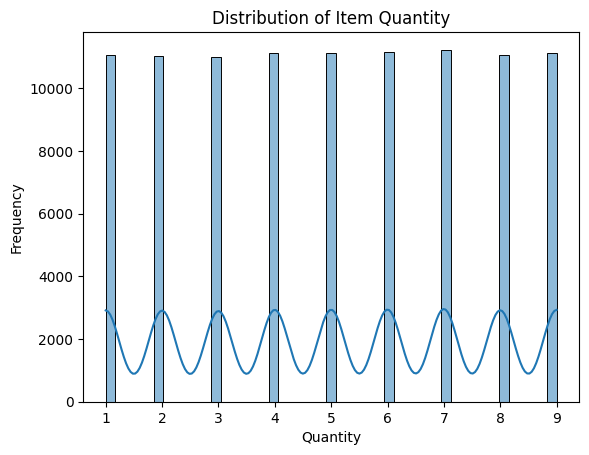

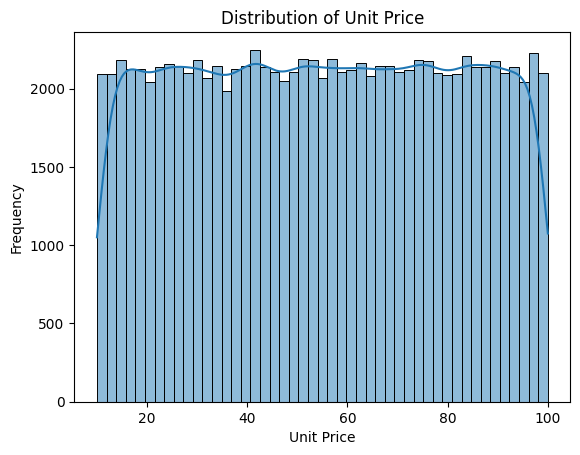

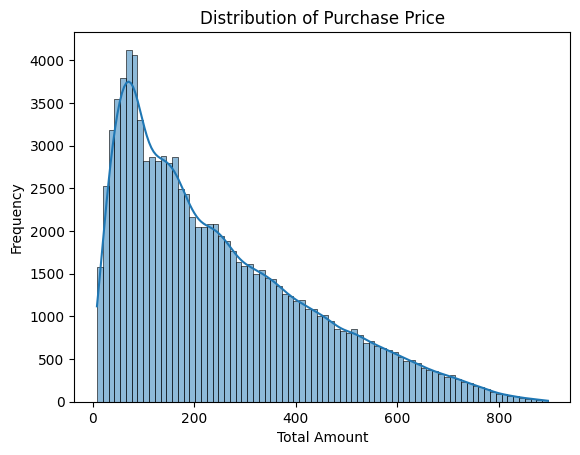

In [8]:
sns.histplot(data=Retail, x='Quantity', kde=True)
plt.title('Distribution of Item Quantity')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.show()

sns.histplot(data=Retail, x='Price', kde=True)
plt.title('Distribution of Unit Price')
plt.xlabel('Unit Price')
plt.ylabel('Frequency')
plt.show()

sns.histplot(data=Retail, x='TotalAmount', kde=True)
plt.title('Distribution of Purchase Price')
plt.xlabel('Total Amount')
plt.ylabel('Frequency')
plt.show()

In [9]:
average_quantity_per_payment = Retail.groupby('PaymentMethod')['Quantity'].mean().sort_values(ascending=False)

C:\Users\17185\AppData\Local\Temp\ipykernel_39272\2798948772.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=average_quantity_per_payment.index, y=average_quantity_per_payment.values, palette='Set2')


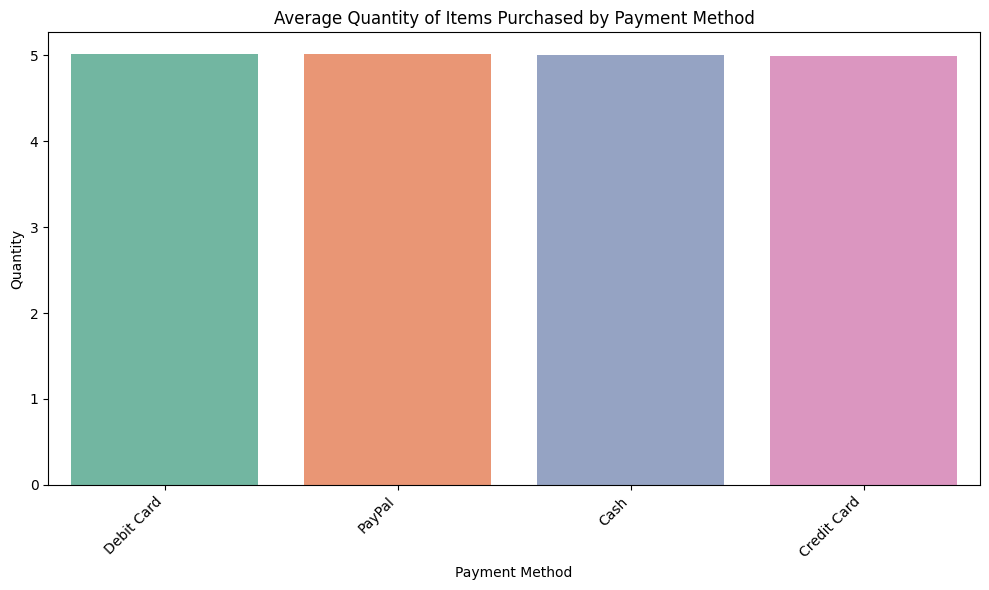

In [10]:
plt.figure(figsize=(10, 6))
sns.barplot(x=average_quantity_per_payment.index, y=average_quantity_per_payment.values, palette='Set2')
plt.title('Average Quantity of Items Purchased by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Quantity')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [11]:
Retail.dtypes

CustomerID              int64
ProductID              object
Quantity                int64
Price                 float64
TransactionDate        object
PaymentMethod          object
StoreLocation          object
ProductCategory        object
DiscountApplied(%)    float64
TotalAmount           float64
dtype: object

In [ ]:
### Key EDA Insights

- Transaction values are right-skewed, with a small number of high-value purchases
- Purchase quantities cluster around small basket sizes
- Payment methods are evenly distributed, suggesting no single dominant channel
- Product categories show variation in average transaction value

In [ ]:
Retail['TransactionDate'] = pd.to_datetime(Retail['TransactionDate'])

reference_date = Retail['TransactionDate'].max() + pd.Timedelta(days=1)

rfm = Retail.groupby('CustomerID').agg({
    'TransactionDate': lambda x: (reference_date - x.max()).days,
    'CustomerID': 'count',
    'TotalAmount': 'sum'
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']

rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
14,267,1,256.232791
42,346,1,502.656523
49,329,1,21.399047
59,28,2,249.492696
65,316,1,548.006625


In [13]:
from sklearn.cluster import KMeans

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

rfm.head()

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
14,267,1,256.232791,0
42,346,1,502.656523,3
49,329,1,21.399047,0
59,28,2,249.492696,2
65,316,1,548.006625,3


In [14]:
cluster_summary = rfm.groupby('Cluster').mean().round(2)
cluster_summary

,Recency,Frequency,Monetary
Cluster,,,
0,277.67,1.00,167.62
1,87.96,1.00,166.73
2,119.53,2.04,503.23
3,183.75,1.00,524.88


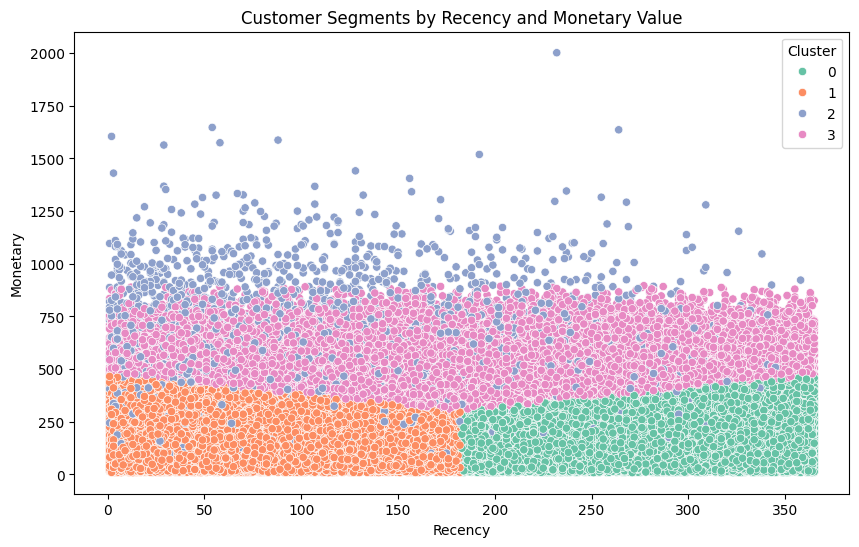

In [15]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=rfm,
    x='Recency',
    y='Monetary',
    hue='Cluster',
    palette='Set2'
)
plt.title('Customer Segments by Recency and Monetary Value')
plt.show()


In [ ]:
## Customer Segment Insights

- Cluster 0: High-value, frequent customers with recent purchases  
  - Ideal targets for loyalty and retention programs

- Cluster 1: Infrequent but high-spend customers  
  - Opportunity for reactivation campaigns

- Cluster 2: Low-frequency, low-spend customers  
  - Minimal marketing investment recommended

- Cluster 3: Recent customers with moderate spend  
  - Upsell and cross-sell opportunities

In [ ]:
## Key Takeaways

- A small subset of customers contributes a disproportionate share of revenue
- Customer behavior varies significantly across recency and spending dimensions
- RFM segmentation provides a scalable framework for targeted retail decision-making

### Next Steps
- Incorporate promotion response data
- Track segment movement over time
- Integrate inventory or product margin data
